   Interest_1_W_Binned  total_purchase_amt  total_redeem_amt
0       (2.211, 2.432]        49142.571047      41146.969116
1       (2.432, 2.653]        45619.534514      32489.712933
2       (2.653, 2.874]        36226.672777      33981.589546
3       (2.874, 3.095]        33135.181797      33247.408897
4       (3.095, 3.316]        28671.113665      25539.205534
5       (3.316, 3.537]        29624.178541      28296.532426
6       (3.537, 3.758]        31930.757462      27108.545899
7        (3.758, 3.98]        36770.187354      31329.004570
8        (3.98, 4.201]        34835.081860      28998.062549
9       (4.201, 4.422]        43004.318769      27095.965633
10      (4.422, 4.643]        60010.644230      30947.356763
11      (4.643, 4.864]        51153.909387      28183.199210
12      (4.864, 5.085]        65610.839522      29877.650056
13      (5.085, 5.306]        88520.648048      38176.844304
14      (5.306, 5.527]        58045.925353      36088.046119
15      (5.527, 5.748]  

/var/folders/w9/jtdtz0sx0573053249v7w9_40000gn/T/ipykernel_82090/2832417656.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = merged_df.groupby('Interest_1_W_Binned')[['total_purchase_amt', 'total_redeem_amt']].mean().reset_index()


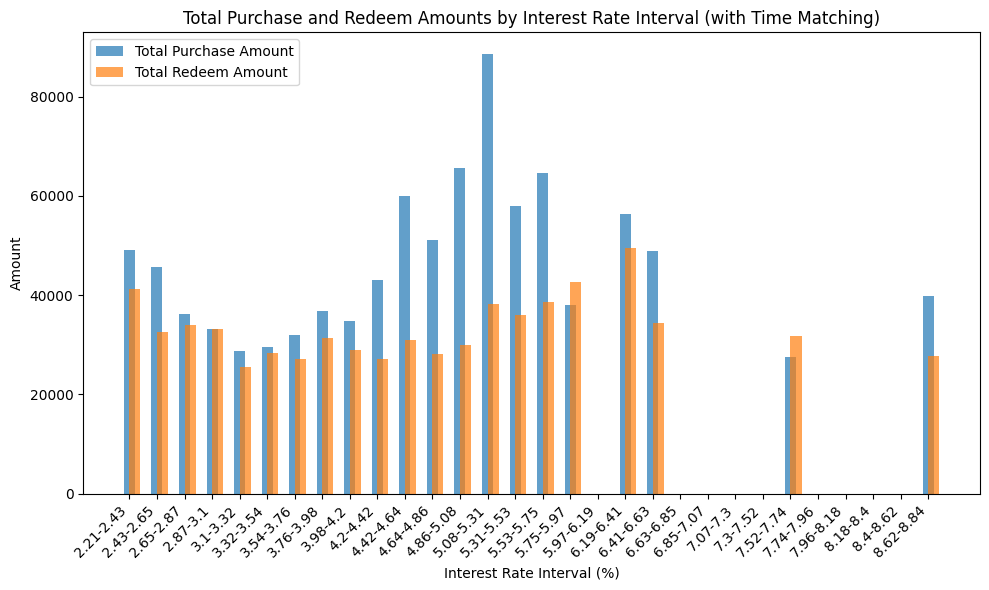

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mfd_bank_shibor_df = pd.read_csv('../PurchaseRedemptionData/mfd_bank_shibor.csv')
user_balance_table_df = pd.read_csv('../PurchaseRedemptionData/user_balance_table.csv')

mfd_bank_shibor_df['mfd_date'] = pd.to_datetime(mfd_bank_shibor_df['mfd_date'], format='%Y%m%d')
user_balance_table_df['report_date'] = pd.to_datetime(user_balance_table_df['report_date'], format='%Y%m%d')
merged_df = pd.merge(user_balance_table_df, mfd_bank_shibor_df, left_on='report_date', right_on='mfd_date', how='inner')
min_interest = merged_df['Interest_1_W'].min()
max_interest = merged_df['Interest_1_W'].max()
interest_bins = np.linspace(min_interest, max_interest, 31)
merged_df['Interest_1_W_Binned'] = pd.cut(merged_df['Interest_1_W'], bins=interest_bins)
result_df = merged_df.groupby('Interest_1_W_Binned')[['total_purchase_amt', 'total_redeem_amt']].mean().reset_index()
print(result_df)

plt.figure(figsize=(10, 6))
x_labels = [f'{round(bin.left, 2)}-{round(bin.right, 2)}' for bin in result_df['Interest_1_W_Binned']]
plt.bar(x_labels, result_df['total_purchase_amt'], width=0.4, label='Total Purchase Amount', alpha=0.7, align='center')
plt.bar(x_labels, result_df['total_redeem_amt'], width=0.4, label='Total Redeem Amount', alpha=0.7, align='edge')
plt.xlabel('Interest Rate Interval (%)')
plt.ylabel('Amount')
plt.title('Total Purchase and Redeem Amounts by Interest Rate Interval (with Time Matching)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
